In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### EDA

In [137]:
data = pd.read_csv('salary_data.csv')
data.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


#### Preprocessing
- Drop na
- Standardize education, gender cols
- Rename cols for easier work

In [138]:
data.rename(columns={
    'Age': 'age',
    'Gender': 'gender',
    'Education Level': 'edu', 
    'Job Title': 'job',
    'Years of Experience':'exp', 
    'Salary': 'salary'}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     6702 non-null   float64
 1   gender  6702 non-null   object 
 2   edu     6701 non-null   object 
 3   job     6702 non-null   object 
 4   exp     6701 non-null   float64
 5   salary  6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [139]:
print(data.isna().sum())
data.dropna(inplace=True)


age       2
gender    2
edu       3
job       2
exp       3
salary    5
dtype: int64


In [140]:
#normalize job titles and education levels
data['gender'] = data['gender'].str.lower().str.strip()
data['job'] = data['job'].str.lower().str.strip()
data['edu'] = data['edu'].str.lower().str.strip()
data['edu'].replace(
    {"bachelor's": "bachelor", 
     "master's": "master", 
     "bachelor's degree": "bachelor",
     "master's degree": "master"}, 
inplace=True)

#### Define Functions

In [141]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
def anova_pairwise_tukeyhsd(df, col1, col2):
    fig = plt.figure(figsize=(4, 2))
    ax1 = fig.add_subplot(1, 1, 1)
    sns.boxplot(x=col1, y=col2, data=df, palette="Set3", ax=ax1)
    plt.show()

    model = ols(f'{col2} ~ C({col1})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table)
    print('\n')
    m_comp = pairwise_tukeyhsd(endog=df[col2], groups=df[col1], alpha=0.05)
    print(m_comp)

In [142]:
from scipy.stats import chi2_contingency, chi2
def plot_crosstab_and_show_dependency(df, col1, col2):
    crosstab = pd.crosstab(df[col1], df[col2])
    crosstab.plot(kind='bar', stacked=True, figsize=(5, 3))
    plt.title(f'{col1} vs {col2}')
    plt.show()

    stat, p, dof, expected =chi2_contingency(crosstab)
    print(f'p-value: {p}')
    print(f'dof: {dof}')

    prob = 0.975
    critical = chi2.ppf(prob, dof)
    print(f'probability: {prob}, critical: {critical}, stat: {stat}')

    alpha = 1 - prob
    print(f'alpha (significant): {alpha}, p-value: {p}')
    if p <= alpha:
        print(f'{col1} dependent {col2} (reject H0)')
    else:
        print(f'{col1} independent {col2}(fail to reject H0)')

In [143]:
def num_univariate_analysis(data, col: str):
    #Descriptive statistics
    print(data[col].describe(include='all'))
    col_median = data[col].median()
    col_mode = data[col].mode().iloc[0]
    col_range = data[col].max() - data[col].min()
    col_variance = data[col].var()
    col_skew = data[col].skew()
    col_kurt = data[col].kurt()

    print(f"Median {col_median}")
    print(f"Mode {col_mode}")
    print(f"Range {col_range}")
    print(f"Var {col_variance}")
    print("****************************************************")

    # Histogram
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 3, 1)
    sns.histplot(data[col], kde=True)
    plt.subplot(1, 3, 2)
    plt.hist(data[col])
    plt.subplot(1, 3, 3)
    plt.pie(data[col].value_counts(), labels=data[col].value_counts().index, autopct='%1.1f%%')
    plt.show()
    print(f"Skew {col_skew}")
    print(f"Kurt {col_kurt}")
    if col_skew > 0:
        print("Phân phối lệch phải")
    else:
        print("Phân phối lệch trái")
    
    if col_kurt > 0:
        print("Phân phối nhọn hơn phân phối chuẩn")
    else:
        print("Phân phối có độ nhọn thấp hơn phân phối chuẩn")
    print("****************************************************")

    col_Q1 = data[col].quantile(0.25)
    col_Q3 = data[col].quantile(0.75)
    col_IQR = col_Q3 - col_Q1
    print(f"Q1 - Q3: {col_Q1} - {col_Q3}")
    print(f"IQR {col_IQR}")

    # Boxplot, Outliers
    plt.figure(figsize=(2,2))
    plt.boxplot(data[col])
    plt.show()
    col_outliers_upper_num = data[data[col] > (col_Q3 + 1.5*col_IQR)].shape[0]
    col_outliers_lower_num = data[data[col] < (col_Q1 - 1.5*col_IQR)].shape[0]
    col_outliers_per = (col_outliers_upper_num + col_outliers_lower_num)/data.shape[0] * 100
    print(f"Number of outliers: {col_outliers_upper_num + col_outliers_lower_num}")
    print(f"Number of upper outliers: {col_outliers_upper_num}")
    print(f"Number of lower outliers: {col_outliers_lower_num}")
    print(f"Percentage of outliers: {col_outliers_per}%")
    # vì outlier có tỉ lệ nhỏ (<1%) nên có thể không cần loại bỏ outlier

In [144]:
class PlotType(enumerate):
    HIST = 'hist'
    PIE = 'pie'
    BAR = 'bar'

def cat_univariate_analysis(data:pd.DataFrame, fig_size=(10, 5), exclude_cols=[], num_cols=3, plot_type=PlotType.HIST):
    i = 0
    category_cols = [col for col in data.columns if data[col].dtype == 'object']
    num_rows = len(category_cols) // num_cols + 1
    fig = plt.figure(figsize=fig_size)
    for col in category_cols:
        if col in exclude_cols:
            continue
        i += 1
        fig.add_subplot(num_rows, num_cols, i)
        if plot_type == PlotType.HIST:
            sns.histplot(data[col])
        elif plot_type == PlotType.PIE:
            plt.pie(data[col].value_counts(), labels=data[col].value_counts().index, autopct='%1.1f%%')
        elif plot_type == PlotType.BAR:
            sns.barplot(x=data[col].value_counts().index, y=data[col].value_counts())
        plt.xticks(rotation=90)
        plt.title(col)
    plt.tight_layout()
    plt.show()

In [145]:
numbers_cols = [col for col in data.columns if data[col].dtype != 'object']
description = data.describe()
modes = data.mode().iloc[0] # (1,33)
description.loc['mode'] = modes
description.loc['var'] = data[numbers_cols].var()
standard_error = data[numbers_cols].sem()
description.loc['std'] = standard_error
kurtosis = data[numbers_cols].kurtosis()
description.loc['kur'] = kurtosis
skewness = data[numbers_cols].skew()
description.loc['skew'] = skewness
range = data[numbers_cols].max() - data[numbers_cols].min()
description.loc['range'] = range
description

,age,exp,salary
count,6698.000000,6698.000000,6.698000e+03
mean,33.623022,8.095178,1.153293e+05
std,0.093056,0.074049,6.450262e+02
min,21.000000,0.000000,3.500000e+02
25%,28.000000,3.000000,7.000000e+04
50%,32.000000,7.000000,1.150000e+05
75%,38.000000,12.000000,1.600000e+05
max,62.000000,34.000000,2.500000e+05
mode,27.000000,2.000000,1.400000e+05
var,58.000169,36.727128,2.786762e+09


#### Number Univariate analysis
- Về exp, mức phổ biến là từ 1 - 9 năm, từ 10 - 20 exp tỉ lệ giảm, và trên 20 - 30 năm tỉ lệ này còn thấp hơn => phân phối lệch phải mạnh, ngoại lai là > 25.5 và có 75 ngoại lai (làm việc nhiều hơn 25.5 năm). Median là 7, mean là 8
- Về age, phổ biến là khoảng 26 - 33 tuổi, ngoài khoảng này ra thì tỉ lệ các nhóm tuổi còn lại khá thấp, đa phần đều là những người nằm trong độ tuổi vàng lao động (22 - 40), mode(xuất hiện nhiều nhất) là 28, mean là 32, Median là 33
- Range salary phổ biến từ 70000$ - 160000$, mode là 140000$, median và mean là 115000$. Phân phối lệch phải và không có ngoại lai

count    6698.000000
mean       33.623022
std         7.615784
min        21.000000
25%        28.000000
50%        32.000000
75%        38.000000
max        62.000000
Name: age, dtype: float64
Median 32.0
Mode 27.0
Range 41.0
Var 58.00016873806444
****************************************************


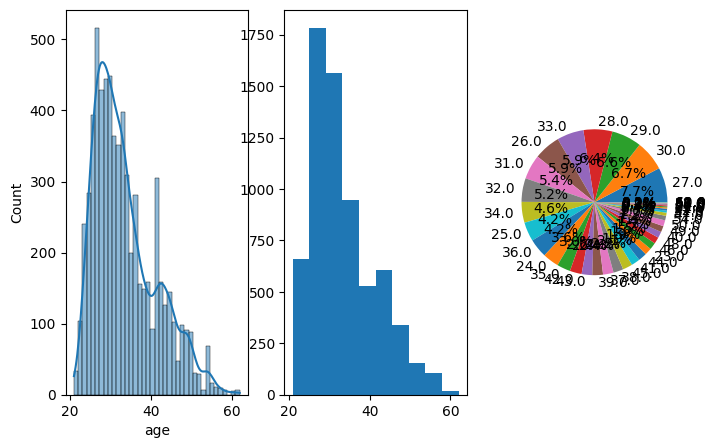

Skew 0.9051232700582525
Kurt 0.18616704509640591
Phân phối lệch phải
Phân phối nhọn hơn phân phối chuẩn
****************************************************
Q1 - Q3: 28.0 - 38.0
IQR 10.0


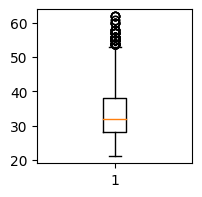

Number of outliers: 123
Number of upper outliers: 123
Number of lower outliers: 0
Percentage of outliers: 1.8363690653926548%


In [146]:
# num_univariate_analysis(data, 'salary')
num_univariate_analysis(data, 'age')
# num_univariate_analysis(data, 'exp')

#### Category Univariate Analysis
Trong tập dữ liệu:
- Nam chiếm 55%, nữ chiếm 45%
- Bằng cấp 3 chiếm 6.7%. Bằng Cứ nhân chiếm 45%, bằng thạc sĩ chiếm 28%, bằng tiến sĩ chiếm 20%
- Data chiếm 18%, Software chiếm 39 - 40%, Khác chiếm 42%

In [147]:
category_cols = [col for col in data.columns if data[col].dtype == 'object']
for col in category_cols:
    print(f"{col} have {data[col].nunique()} unique values: {data[col].unique()}")

gender have 3 unique values: ['male' 'female' 'other']
edu have 4 unique values: ['bachelor' 'master' 'phd' 'high school']
job have 190 unique values: ['software engineer' 'data analyst' 'senior manager' 'sales associate'
 'director' 'marketing analyst' 'product manager' 'sales manager'
 'marketing coordinator' 'senior scientist' 'software developer'
 'hr manager' 'financial analyst' 'project manager' 'customer service rep'
 'operations manager' 'marketing manager' 'senior engineer'
 'data entry clerk' 'sales director' 'business analyst' 'vp of operations'
 'it support' 'recruiter' 'financial manager' 'social media specialist'
 'software manager' 'junior developer' 'senior consultant'
 'product designer' 'ceo' 'accountant' 'data scientist'
 'marketing specialist' 'technical writer' 'hr generalist'
 'project engineer' 'customer success rep' 'sales executive' 'ux designer'
 'operations director' 'network engineer' 'administrative assistant'
 'strategy consultant' 'copywriter' 'account ma

- Ta thấy có nhiều giá trị thực ra là 1 nhưng lại có tên gọi khác => cần chuẩn hóa
- Đây đa phần là nhân sự trong khối ngành công nghệ => có nên chỉ tập trung vào giới công nghệ, data hay không

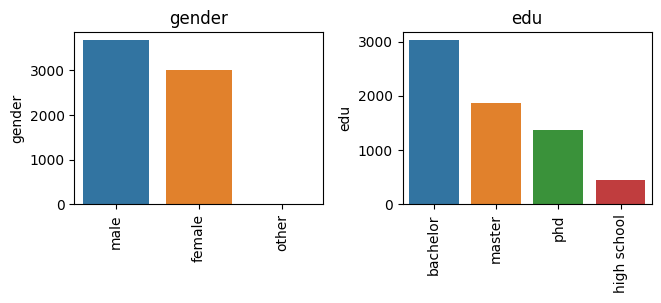

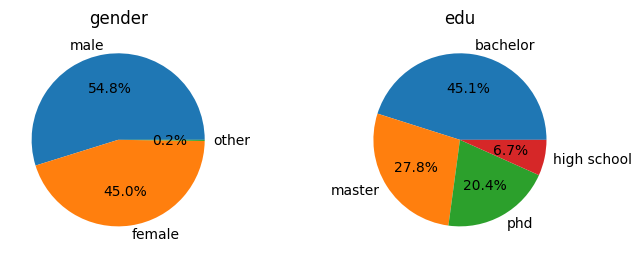

In [148]:
cat_univariate_analysis(data, fig_size=(10, 5), exclude_cols=['job'], num_cols=3, plot_type=PlotType.BAR)
cat_univariate_analysis(data, fig_size=(10, 5), exclude_cols=['job'], num_cols=3, plot_type=PlotType.PIE)

In [149]:
# get values contain Data
data_jobs = data['job'].value_counts().index
data_keywords = ['data', 'analyst']
data_jobs = [job for job in data_jobs if any(keyword in job for keyword in data_keywords)]

remove_jobs = ['data entry clerk', 'help desk analyst']
data_jobs = [job for job in data_jobs if job not in remove_jobs]
data_jobs


['data scientist',
 'data analyst',
 'marketing analyst',
 'senior data scientist',
 'director of data science',
 'financial analyst',
 'junior data analyst',
 'senior business analyst',
 'senior marketing analyst',
 'junior business analyst',
 'senior financial analyst',
 'junior financial analyst',
 'junior operations analyst',
 'senior data engineer',
 'junior marketing analyst',
 'senior data analyst',
 'junior business operations analyst',
 'senior operations analyst',
 'business analyst',
 'senior quality assurance analyst',
 'junior data scientist',
 'supply chain analyst',
 'chief data officer',
 'operations analyst',
 'business intelligence analyst']

In [150]:
software_jobs = data['job'].value_counts().index
software_keywords = [
    'software', 'engineer', 
    'developer', 'programmer', 
    'mobile', 'full stack', 
    'front end', 'back end', 'web']
remove_jobs = ['software project manager', 'network engineer', 'project engineer', 'junior web designer', 'senior data engineer']
software_jobs = [job for job in software_jobs if any(keyword in job for keyword in software_keywords)]
software_jobs = [job for job in software_jobs if job not in remove_jobs]
software_jobs

['software engineer',
 'software engineer manager',
 'senior project engineer',
 'full stack engineer',
 'front end developer',
 'senior software engineer',
 'back end developer',
 'software developer',
 'web developer',
 'junior software developer',
 'junior software engineer',
 'junior web developer',
 'senior software developer',
 'director of engineering',
 'senior engineer',
 'junior developer',
 'software manager',
 'senior software architect',
 'principal engineer']

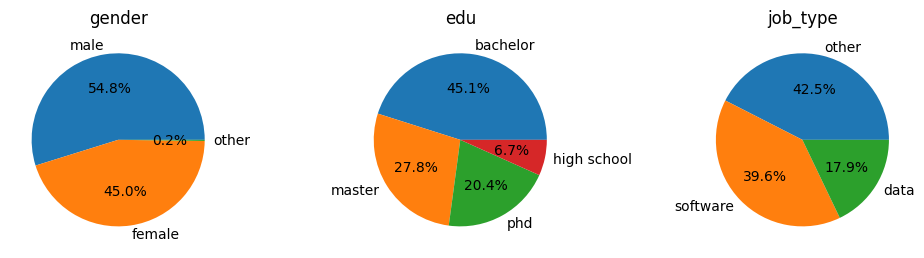

In [151]:
data['job_type'] = data['job'].apply(lambda x: 'data' if x in data_jobs else ('software' if x in software_jobs else 'other'))
cat_univariate_analysis(data, fig_size=(10, 5), exclude_cols=['job'], num_cols=3, plot_type=PlotType.PIE)

#### Number vs Number Multivariate Analysis
Dựa vào correlation matrix, Ta thấy exp và age tương quan mạnh, điều này là dễ hiểu, vì càng làm lâu thì tuổi càng lớn, có một số người thì bắt đầu sự nghiệp muộn. Salary tương quan mạnh với exp hơn là với age. 

Theo T-test hypothesis test
- mean salar data jobs > mean age software jobs 7.34
- mean age data jobs < mean age software jobs 5.38
- mean exp data jobs < mean age software jobs 2.14 

Data là ngành mới hơn và có nhiều tiềm năng phát triển hơn, nhưng số lượng job được báo cáo cũng ít hơn (xem lại ở trên)

In [152]:
data.corr()

C:\Users\PC\AppData\Local\Temp\ipykernel_13092\2627137660.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,age,exp,salary
age,1.000000,0.937725,0.728061
exp,0.937725,1.000000,0.808968
salary,0.728061,0.808968,1.000000


In [153]:
df_data = data[data['job'].isin(data_jobs)]
df_software = data[data['job'].isin(software_jobs)]

# univariate_analysis(df_data, 'salary')
# plt.hist(df_data['job'])
# plt.xticks(rotation=90)
# num_univariate_analysis(df_data, 'age')

# univariate_analysis(df_software, 'salary')
# plt.hist(df_software['job'])
# plt.xticks(rotation=90)
# num_univariate_analysis(df_software, 'age')

print(f'software age: {df_software["age"].mean()} vs data age: {df_data["age"].mean()}')
print(f'min software age: {df_software["age"].min()} vs min data age: {df_data["age"].min()}')
print(f'max software age: {df_software["age"].max()} vs max data age: {df_data["age"].max()}')
print('*******************************************')
print(f'software salary: {df_software["salary"].mean()} vs data salary: {df_data["salary"].mean()}')
print(f'min software salary: {df_software["salary"].min()} vs min data salary: {df_data["salary"].min()}')
print(f'max software salary: {df_software["salary"].max()} vs max data salary: {df_data["salary"].max()}')
print('*******************************************')
print(f'software exp: {df_software["exp"].mean()} vs data exp: {df_data["exp"].mean()}')
print(f'min software exp: {df_software["exp"].min()} vs min data exp: {df_data["exp"].min()}')
print(f'max software exp: {df_software["exp"].max()} vs max data exp: {df_data["exp"].max()}')
#TODO hypothesis test
print('*******************************************')
# T-test
from scipy.stats import ttest_ind
print(ttest_ind(df_data['salary'], df_software['salary']))
print(ttest_ind(df_data['age'], df_software['age']))
print(ttest_ind(df_data['exp'], df_software['exp']))
# pvalue < 0.05 => reject H0 => có sự khác biệt về mức lương tb giữa 2 nhóm data và software

# ANOVA
# from scipy.stats import f_oneway
# print(f_oneway(df_data['salary'], df_software['salary']))
# pvalue < 0.05 => reject H0 => có sự khác biệt về mức lương giữa 2 nhóm data và software

software age: 34.49698568198945 vs data age: 32.92904841402337
min software age: 22.0 vs min data age: 23.0
max software age: 62.0 vs max data age: 51.0
*******************************************
software salary: 121310.28146194424 vs data salary: 134059.55759599333
min software salary: 550.0 vs min data salary: 350.0
max software salary: 210000.0 vs max data salary: 240000.0
*******************************************
software exp: 8.61266013564431 vs data exp: 8.121035058430717
min software exp: 0.0 vs min data exp: 0.0
max software exp: 34.0 vs max data exp: 24.0
*******************************************
Ttest_indResult(statistic=7.347542708314707, pvalue=2.4520697280429126e-13)
Ttest_indResult(statistic=-5.384563325031524, pvalue=7.695835959208369e-08)
Ttest_indResult(statistic=-2.142214311061264, pvalue=0.03223878852821191)


#### Category vs Category Multivariate Analysis
Dựa vào chi2 dependency hypothesis testing, ta kết luận
- Trong ngành software và data, gender là male chiếm cao hơn female
- Trong nhóm ngành software và data, tỉ lệ người có bằng high school cực thấp, đặc biệt trong ngành data, tỉ trọng người có bằng tiến sĩ rất cao
- Trình độ học vấn có phụ thuộc vào edu

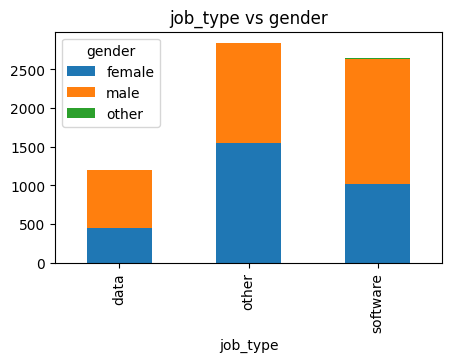

p-value: 3.955523959913903e-42
dof: 4
probability: 0.975, critical: 11.143286781877796, stat: 199.89613405939775
alpha (significant): 0.025000000000000022, p-value: 3.955523959913903e-42
job_type dependent gender (reject H0)


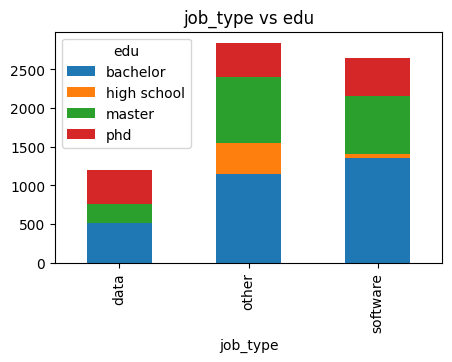

p-value: 1.0612605086750829e-145
dof: 6
probability: 0.975, critical: 14.44937533544792, stat: 689.6280893595821
alpha (significant): 0.025000000000000022, p-value: 1.0612605086750829e-145
job_type dependent edu (reject H0)


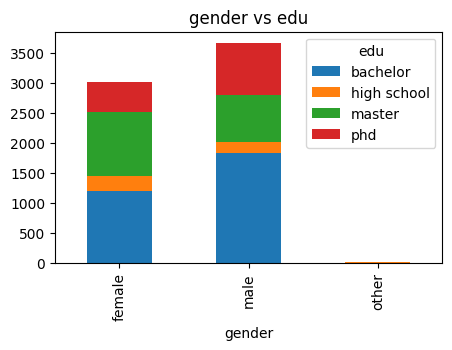

p-value: 2.764381562593269e-75
dof: 6
probability: 0.975, critical: 14.44937533544792, stat: 362.7926232411433
alpha (significant): 0.025000000000000022, p-value: 2.764381562593269e-75
gender dependent edu (reject H0)


In [154]:
plot_crosstab_and_show_dependency(data, 'job_type', 'gender')
plot_crosstab_and_show_dependency(data, 'job_type', 'edu')
plot_crosstab_and_show_dependency(data, 'gender', 'edu')

#### Category vs Number Multivariate Analysis
- Mức lương của ngành data là cao nhất, cao hơn software là 12749$, cao hơn các nhóm ngành khác là 32192$
- Tuổi của nhóm ngành software cao hơn data và nhóm ngành khác 1,5 năm ???
- Kinh nghiệm của nhóm ngành software so với các nhóm ngành khác là hơn 1 năm ???
- Lương có ảnh hưởng bới bằng cấp, từ bằng phổ thông lên bằng cử nhân, mức lương tăng 60,000$. Sau đó với mỗi cấp tăng lên thì mức lương tăng 35,000$
- Lương của nam thì cao hơn 12000$ so với nữ, nhưng số năm kinh nghiệm và tuổi của nhân sự nam cũng cao hơn khoảng 1 - 1.2 năm => sự chênh lệch lương là hợp lí (hãy thử vào nhóm other, xem xét xem những yếu tố này có khác hay không)

- Trình độ học vấn các người giới tính other thấp hơn nhóm nam / nữ là 1, giữa nam và nữ không khác biệt về trình độ học vấn (cụ thể hơn chi2 ở trên)
- Trình độ học vấn các ngành về data cao hơn nhóm ngành thuộc software, software lại cao hơn nhóm ngành khác

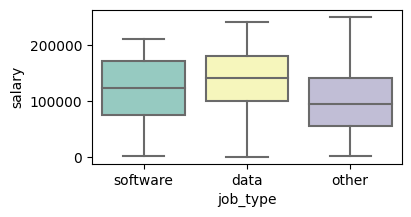

                   sum_sq      df           F        PR(>F)
C(job_type)  1.030988e+12     2.0  195.737295  2.425839e-83
Residual     1.763196e+13  6695.0         NaN           NaN


      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1  group2    meandiff  p-adj    lower       upper    reject
----------------------------------------------------------------
  data    other -32192.1999   0.0 -36335.3783 -28049.0215   True
  data software -12749.2761   0.0 -16936.6157  -8561.9365   True
 other software  19442.9238   0.0  16196.6335   22689.214   True
----------------------------------------------------------------


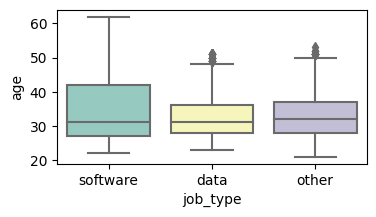

                    sum_sq      df          F        PR(>F)
C(job_type)    3382.225094     2.0  29.404359  1.930231e-13
Residual     385044.904944  6695.0        NaN           NaN


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
  data    other   0.1711 0.7895 -0.4412 0.7834  False
  data software   1.5679    0.0  0.9491 2.1867   True
 other software   1.3968    0.0  0.9171 1.8766   True
-----------------------------------------------------


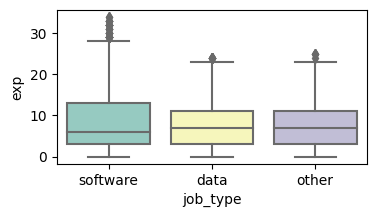

                    sum_sq      df          F        PR(>F)
C(job_type)    1404.508139     2.0  19.224924  4.727216e-09
Residual     244557.066100  6695.0        NaN           NaN


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
  data    other  -0.5193 0.0338 -1.0073 -0.0314   True
  data software   0.4916 0.0509 -0.0015  0.9848  False
 other software   1.0109    0.0  0.6286  1.3933   True
------------------------------------------------------


In [155]:
anova_pairwise_tukeyhsd(data, 'job_type', 'salary')
anova_pairwise_tukeyhsd(data, 'job_type', 'age')
anova_pairwise_tukeyhsd(data, 'job_type', 'exp')

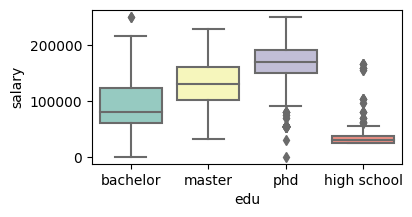

                sum_sq      df            F  PR(>F)
C(edu)    7.880887e+12     3.0  1630.939353     0.0
Residual  1.078206e+13  6694.0          NaN     NaN


          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
   group1      group2     meandiff  p-adj    lower       upper    reject
------------------------------------------------------------------------
   bachelor high school -58376.2144   0.0 -63597.4627 -53154.9661   True
   bachelor      master  35029.1478   0.0  31989.5989  38068.6967   True
   bachelor         phd  70568.5494   0.0  67208.5303  73928.5684   True
high school      master  93405.3623   0.0  87977.7478  98832.9767   True
high school         phd 128944.7638   0.0 123331.3986  134558.129   True
     master         phd  35539.4015   0.0  31866.8966  39211.9065   True
------------------------------------------------------------------------


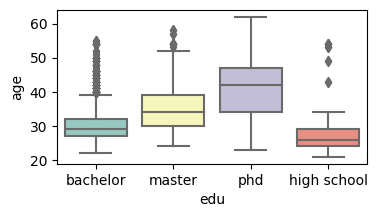

                 sum_sq      df            F  PR(>F)
C(edu)    136806.601357     3.0  1213.180544     0.0
Residual  251620.528682  6694.0          NaN     NaN


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
   bachelor high school  -3.4053   0.0 -4.2029 -2.6076   True
   bachelor      master   4.9113   0.0   4.447  5.3757   True
   bachelor         phd  10.8947   0.0 10.3814  11.408   True
high school      master   8.3166   0.0  7.4874  9.1457   True
high school         phd  14.2999   0.0 13.4424 15.1575   True
     master         phd   5.9834   0.0  5.4223  6.5444   True
-------------------------------------------------------------


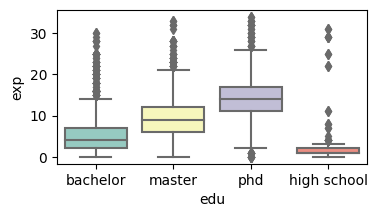

                 sum_sq      df            F  PR(>F)
C(edu)     89581.657111     3.0  1278.211047     0.0
Residual  156379.917128  6694.0          NaN     NaN


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
   bachelor high school  -3.5044   0.0 -4.1332 -2.8756   True
   bachelor      master   4.2261   0.0  3.8601  4.5922   True
   bachelor         phd   8.4957   0.0  8.0911  8.9004   True
high school      master   7.7305   0.0  7.0769  8.3842   True
high school         phd  12.0001   0.0 11.3241 12.6761   True
     master         phd   4.2696   0.0  3.8273  4.7119   True
-------------------------------------------------------------


In [156]:
anova_pairwise_tukeyhsd(data, 'edu', 'salary')
anova_pairwise_tukeyhsd(data, 'edu', 'age')
anova_pairwise_tukeyhsd(data, 'edu', 'exp')

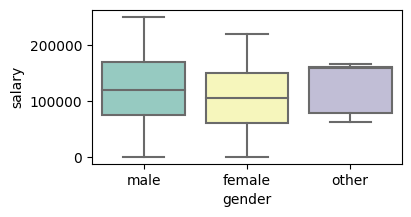

                 sum_sq      df          F        PR(>F)
C(gender)  3.034465e+11     2.0  55.327602  1.472103e-24
Residual   1.835950e+13  6695.0        NaN           NaN


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
female   male  13506.699    0.0   10488.968 16524.4299   True
female  other 17980.8585 0.4055 -14904.0537 50865.7706  False
  male  other  4474.1595 0.9454  -28397.119  37345.438  False
-------------------------------------------------------------


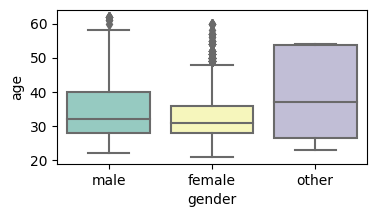

                  sum_sq      df          F        PR(>F)
C(gender)    5811.188153     2.0  50.841981  1.217892e-22
Residual   382615.941886  6695.0        NaN           NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
female   male   1.7921    0.0 1.3565  2.2278   True
female  other   6.9451 0.0018 2.1978 11.6925   True
  male  other    5.153 0.0294 0.4077  9.8984   True
---------------------------------------------------


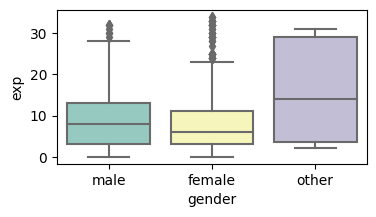

                  sum_sq      df          F        PR(>F)
C(gender)    3346.194852     2.0  46.169321  1.218806e-20
Residual   242615.379386  6695.0        NaN           NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower   upper  reject
--------------------------------------------------
female   male   1.1972   0.0 0.8503  1.5441   True
female  other   9.0084   0.0 5.2281 12.7887   True
  male  other   7.8112   0.0 4.0324 11.5899   True
--------------------------------------------------


In [157]:
anova_pairwise_tukeyhsd(data, 'gender', 'salary')
anova_pairwise_tukeyhsd(data, 'gender', 'age')
anova_pairwise_tukeyhsd(data, 'gender', 'exp')

In [158]:
data['edu_num'] = data['edu'].replace({
    'high school': 0, 
    'bachelor': 1, 
    'master': 2, 
    'phd': 3})

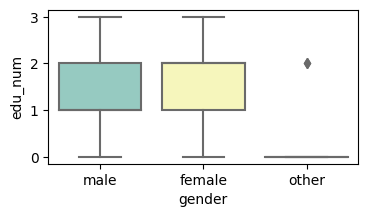

                sum_sq      df         F        PR(>F)
C(gender)    27.612461     2.0  17.82661  1.899080e-08
Residual   5185.097602  6695.0       NaN           NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
female   male     0.04 0.1535 -0.0107  0.0907  False
female  other  -1.3147    0.0 -1.8673  -0.762   True
  male  other  -1.3547    0.0 -1.9071 -0.8023   True
----------------------------------------------------


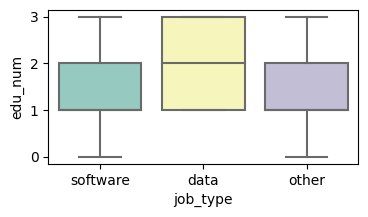

                  sum_sq      df           F        PR(>F)
C(job_type)   184.393886     2.0  122.756508  4.383091e-53
Residual     5028.316176  6695.0         NaN           NaN


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
  data    other  -0.4644   0.0 -0.5344 -0.3945   True
  data software  -0.2872   0.0 -0.3579 -0.2164   True
 other software   0.1773   0.0  0.1225  0.2321   True
-----------------------------------------------------


In [162]:
anova_pairwise_tukeyhsd(data, 'gender', 'edu_num')
anova_pairwise_tukeyhsd(data, 'job_type', 'edu_num')

### Insight

       age  gender          edu                   job   exp    salary  \
0     32.0    male     bachelor     software engineer   5.0   90000.0   
1     28.0  female       master          data analyst   3.0   65000.0   
2     45.0    male          phd        senior manager  15.0  150000.0   
3     36.0  female     bachelor       sales associate   7.0   60000.0   
4     52.0    male       master              director  20.0  200000.0   
...    ...     ...          ...                   ...   ...       ...   
6277  30.0  female  high school       sales executive   2.0   40000.0   
6279  29.0  female       master  sales representative   4.0   55000.0   
6288  27.0    male  high school       sales executive   2.0   40000.0   
6290  28.0    male       master  sales representative   2.0   40000.0   
6297  23.0  female     bachelor       sales executive   1.0   35000.0   

      job_type  
0     software  
1         data  
2        other  
3        other  
4        other  
...        ...  
6277

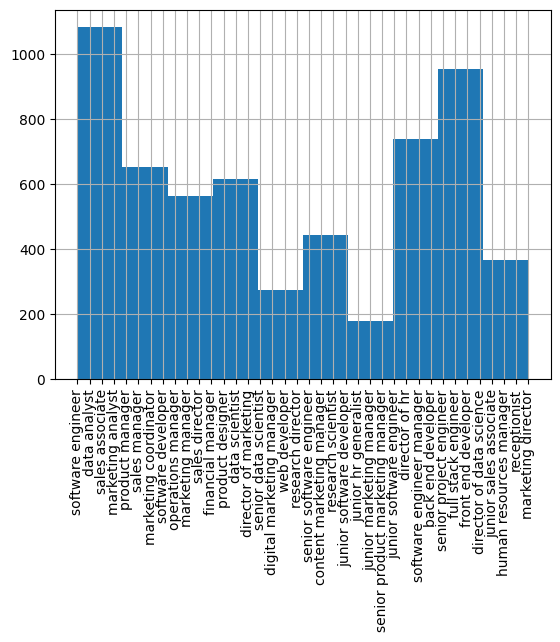

In [ ]:
# filter job title with more than 10 data points
filtered_job_title = data.groupby('job')
print(filtered_job_title.head(5))
filtered_job_title = filtered_job_title.filter(lambda x: len(x) > 50)  # one x contain multiple employee (rows)
filtered_job_title.reset_index(drop=True, inplace=True)
filtered_job_title['job'].hist()
plt.xticks(rotation=90)
plt.show()

#### Histogram of ages, role, education and by gender

C:\Users\PC\AppData\Local\Temp\ipykernel_13092\3809689501.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)
C:\Users\PC\AppData\Local\Temp\ipykernel_13092\3809689501.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 3)
C:\Users\PC\AppData\Local\Temp\ipykernel_13092\3809689501.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, 4)


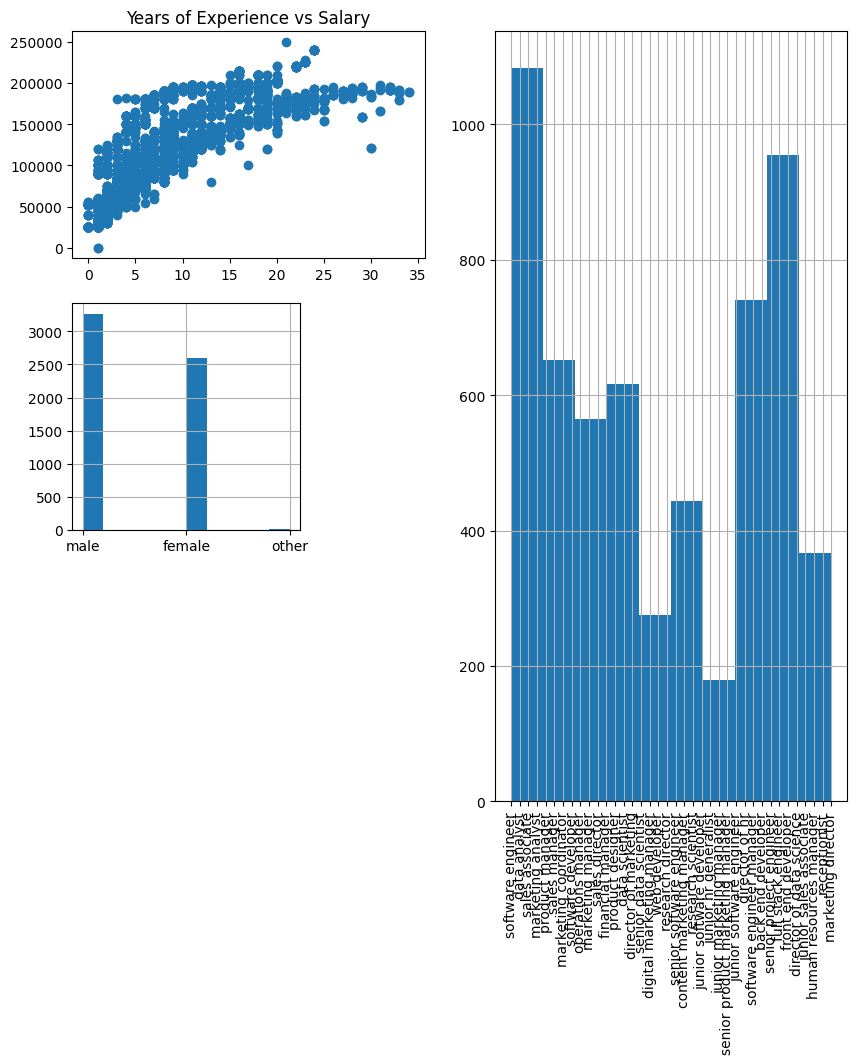

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes[0, 0].scatter(filtered_job_title['exp'], filtered_job_title['salary'])
axes[0, 0].set_title('Years of Experience vs Salary')

plt.subplot(1, 2, 2)
filtered_job_title['job'].hist()
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
filtered_job_title['edu'].hist()
plt.xticks(rotation=90)

plt.subplot(3, 3, 4)
filtered_job_title['gender'].hist()
plt.show()

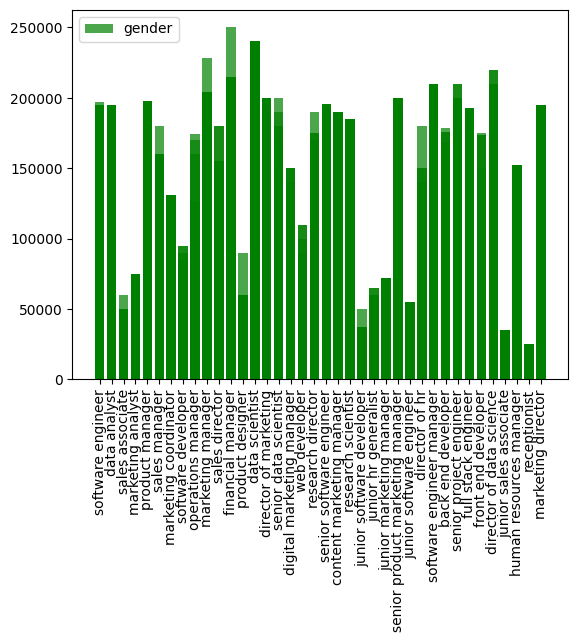

In [ ]:
plt.bar(x=filtered_job_title['job'], height=filtered_job_title['salary'], color='green', alpha=0.7, label='gender')
plt.legend(loc=2)
plt.xticks(rotation=90)
plt.show()